# Expected Performance Tests

In this notebook, I will be focusing on understanding and using a ResNet.

In order to ascertain the expected performance of the (later developed) CNN, I will be using the aforementioned ResNet for classification on the raw dataset. This will allow for a fair comparison/tradeoff between understanding if my developed model is under/over performing.

In other words, the transfer learning results will be used as a performance reference.

## Why ResNet?

### Concept

The concept of a Residual Network was conceived when dealing with the vanishing gradient problem related to Deep Neural Networks, an issue that led to inneficient/irrelevant weight updates, significantly increasing training time and simmultaneous performance degradation.

ResNets represent a type of architecture capable of learning **Residual Functions** instead of attempting to perfect full transformations, which allows for implementation of deeper networks while potentially avoiding exploding/vanishing gradients. 

### Learning
 
Instead of attempting to learn the function that transforms the inputs into outputs, a ResNet learns the residual, which represents the difference between te input and output. Essentially, it identifies small transformations for the input, which is usually much easier to learn, as a residual represents an approximation of the actual function.

Choosing the simplest, most shallow version of ResNet allows for a good starting point of expectd performance, as it will attempt to learn approximations of transformations for the DICOM data in the numpy arrays.

### Architecture


<div style="width: 70%; margin: 0 auto; text-align: center;">
    <img src="../z_imgs/ResNet-18-Architecture.png" alt="Hounsfield Units">
</div>


### Implementation

I will start by importing all necessary libraries, as well as the model itself:

In [29]:
from sklearn.metrics import f1_score, confusion_matrix, roc_curve, auc
from scipy.ndimage import gaussian_filter
import torch.nn.functional as F
import matplotlib.pyplot as plt
import albumentations as A
from tqdm import tqdm
import pandas as pd
import numpy as np
import pickle
import random
import os


# -----------  ResNet -----------

# Core library
import torch

# Essentials for development
import torch.nn as nn
import torchvision.models as models
from torchvision.models import ResNet18_Weights

# Data resize (ResNet uses (224,224) inputs)
import torchvision.transforms as transforms
from torchvision.transforms import ToTensor

# Allows for paralell batch processing
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torchvision.io import decode_image

In [30]:
# Loads the model
resnet18_example = models.resnet18(weights=ResNet18_Weights.DEFAULT)

The original ResNet18 was designed for ImageNet, which has 1000 possible classes. Since our problem consists of binary classification, the last layer needs the following modification:

In [31]:
num_ftrs = resnet18_example.fc.in_features
resnet18_example.fc = nn.Linear(num_ftrs, 2)  

In [32]:
# Resizing numpy arrays
transform = transforms.Resize((224, 224))

In order to obtain valid results, the train test split must be done following the recommended data division. Every slice ID starting with "SerieCT" is to be used as a test/validation split.

In [33]:
# Loads the dataframe
df_fibrosis = pd.read_pickle(r'..\..\\fibrosis_data.pkl')

In [34]:
df_fibrosis.head()

,SliceID,SliceData,Class
0,101__CT-0002-0001,"[[-2000.0, -2000.0, -2000.0, -2000.0, -2000.0,...",0
1,101__CT-0002-0002,"[[-2000.0, -2000.0, -2000.0, -2000.0, -2000.0,...",0
2,101__CT-0002-0003,"[[-2000.0, -2000.0, -2000.0, -2000.0, -2000.0,...",0
3,101__CT-0002-0004,"[[-2000.0, -2000.0, -2000.0, -2000.0, -2000.0,...",0
4,101__CT-0002-0005,"[[-2000.0, -2000.0, -2000.0, -2000.0, -2000.0,...",0


## From Dataframe to Dataset

Torch expects a Dataset instead of a Dataframe. In order to avoid complex transformations, I will be creating a `Dataset` class based on the previously defined df_fibrosis Dataframe, capable of reading the .np arrays as content.

In this case, we will have a `csv` file containing every ID and respective label (**annotations_file**) as well as a directory containing data pertaining to the DICOM slice images (**img_dir**). 

In [35]:
df_annotations = df_fibrosis.drop(columns="SliceData")
df_annotations["SliceID"] = df_annotations["SliceID"].astype(str) + ".npy" # better for data loader
df_annotations.head()

,SliceID,Class
0,101__CT-0002-0001.npy,0
1,101__CT-0002-0002.npy,0
2,101__CT-0002-0003.npy,0
3,101__CT-0002-0004.npy,0
4,101__CT-0002-0005.npy,0


Since ResNet has been trained to use only RGB images and DICOM images are in grayscale, I have chosen to [implement this approach](https://stackoverflow.com/questions/51995977/how-can-i-use-a-pre-trained-neural-network-with-grayscale-images):

"There is an easy way, though, which you can make your model work with grayscale images. You just need to make the image to appear to be RGB. The easiest way to do so is to repeat the image array 3 times on a new dimension. Because you will have the same image over all 3 channels, the performance of the model should be the same as it was on RGB images.

In numpy this can be easily done like this:"

```py
print(grayscale_batch.shape)  # (64, 224, 224)
rgb_batch = np.repeat(grayscale_batch[..., np.newaxis], 3, -1)
print(rgb_batch.shape)  # (64, 224, 224, 3)
```

In PyTorch, this can be done like so:

```python
transforms.Lambda(lambda x: x.repeat(3, 1, 1)),  # Convert (1, H, W) → (3, H, W)
```

 - **Input shape**: The input `x` is a single-channel (grayscale) image of shape `(1, H, W)` (where `H` is the height and `W` is the width of the image).
 - **`x.repeat(3, 1, 1)`**: This repeats the grayscale image along the first axis (the channel axis) three times. The resulting shape is `(3, H, W)`, which means that the image now appears to have three channels, one for each of Red, Green, and Blue. **Each of these channels contains the same pixel values as the original grayscale image.**

### Data Integrity
This approach does not alter the original pixel values in the image. It simply duplicates the grayscale image across all three channels. The integrity of the data is preserved because no new information is added to the image—each of the three channels contains the same grayscale values.

In [36]:
class FibrosisDataset(Dataset):
    def __init__(self, annotations_file, img_dir, transform=None, target_transform=None, albumentations=None, gauss=False):
        self.img_labels = pd.read_csv(annotations_file)
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform
        self.albumentations = albumentations
        self.gauss = gauss

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        # idx represents index
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])

        # Load the .npy file
        image = np.load(img_path)
        
        #image = read_image(img_path)
        label = self.img_labels.iloc[idx, 1]

        # Adds random set of augmentations
        if self.albumentations:
            augmented = self.albumentations(image=image)
            image = augmented['image']

        # Adds randomly selected gauss noise or blur
        if self.gauss:
            # Gaussian Noise
            gauss_noise = image + np.random.normal(loc=0, scale=random.choice(range(10,40)), size=image.shape)
            # Gaussian Blur
            gauss_blur = gaussian_filter(image, sigma=(random.choice(range(10,16))/10)) 
            # Random choice
            image = random.choice((gauss_noise,gauss_blur))

        # Guarantee compatibility
        if self.gauss or self.albumentations: image = image.astype(np.float32)

        # Applies necessary ResNet input transformations
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        
        return image, label

All of the train-test-validation splits were previously doccumented and performed in `2 - testSplit`:

In [37]:
# Paths
img_dir = r"..\..\np_ROI_data"
annotations_file_train = r"trainTestHRCT\train_hrct.csv"
annotations_file_test = r"trainTestHRCT\test_hrct.csv"
annotations_file_val = r"trainTestHRCT\val_hrct.csv"


# Transformations 
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((224, 224)),  # Resize images to 224x224
    transforms.Lambda(lambda x: x.repeat(3, 1, 1)),  # Convert (1, H, W) → (3, H, W)
])

# Create Datasets
train_dataset = FibrosisDataset(annotations_file_train, img_dir=img_dir, transform=transform)
test_dataset = FibrosisDataset(annotations_file_test, img_dir=img_dir, transform=transform)
val_dataset = FibrosisDataset(annotations_file_val, img_dir=img_dir, transform=transform)

Let's check if the contents changed to tensor and represent an image of size ((224,224)) with 1 grayscale dimension (adapted to 3 RGB):

In [38]:
def checkShape(train_dataset, dataset_size=len(train_dataset)):

    # Random choice of Slice
    idx = random.choice(range(dataset_size))

    # Identifies name of file corresponding to the first line of the train dataset
    slice_id = train_dataset.img_labels.iloc[idx, 0]  
    print(f"SliceID at index {idx}: {slice_id}")

    # Pulls first index of value of pandas series element with corresponding id -> 
    # -> gets np array and displays original shape
    print("\nOriginal np.array shape:")
    print((df_fibrosis["SliceData"][df_fibrosis["SliceID"] == slice_id[:-4]]).values[0].shape)

    print("----------------------")

    # Pulls "image" value from the (image, label) pair in the train dataset -> 
    # -> gets torch tensor and displays new shape
    print("\nTransformed tensor shape:")
    print(train_dataset[idx][0].shape)

In [39]:
checkShape(train_dataset)

SliceID at index 20: 105__CT-5662-0021.npy

Original np.array shape:
(512, 512)
----------------------

Transformed tensor shape:
torch.Size([3, 224, 224])


In [40]:
def tensorVSnp(dataset, rgb=True):

    # Random choice of Slice
    idx = random.choice(range(len(dataset)))

    # Identifies name of file corresponding to random line of the train dataset
    slice_id = dataset.img_labels.iloc[idx, 0]  
    print(f"SliceID at index {idx}: {slice_id}")

    # Pulls first index of value of pandas series element with corresponding id -> 
    # -> gets np array 
    np_array = (df_fibrosis["SliceData"][df_fibrosis["SliceID"] == slice_id[:-4]]).values[0]

    # Pulls "image" value from the (image, label) pair in the train dataset -> 
    # -> gets torch tensor 
    tensor_rgb = (dataset[idx][0])

    # Normalize tensor (needed for plotting)
    full_tensor_rgb = (tensor_rgb - tensor_rgb.min()) / (tensor_rgb.max() - tensor_rgb.min())

    # Convert PyTorch tensor to NumPy (swaps dimension orders for compatibility with plot)
    full_tensor_rgb_np = full_tensor_rgb.permute(1, 2, 0).cpu().numpy()
    tensor_rgb_np = tensor_rgb.permute(1, 2, 0).cpu().numpy()

    print(tensor_rgb_np.shape)

    # Plot images
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))

    # Numpy Image
    axes[0].imshow(np_array, cmap='gray')  
    axes[0].set_title("Original np.array")

    # Tensor Image (full RGB)
    axes[1].imshow(full_tensor_rgb_np)  
    axes[1].set_title("Transformed Tensor")

    # ----------- RGB

    if rgb:

        # Separate plot for RGB channels 
        fig2, axes2 = plt.subplots(1, 3, figsize=(15, 5))

        # Display the Red channel
        axes2[0].imshow(tensor_rgb_np[:, :, 0], cmap="gray")  # R channel
        axes2[0].set_title("Red Channel")

        # Display the Green channel
        axes2[1].imshow(tensor_rgb_np[:, :, 1], cmap="gray")  # G channel
        axes2[1].set_title("Green Channel")

        # Display the Blue channel
        axes2[2].imshow(tensor_rgb_np[:, :, 2], cmap="gray")  # B channel
        axes2[2].set_title("Blue Channel")

    plt.show()

SliceID at index 2090: 8__CT-INSPIRIUM-8871__CT-8871-0009.npy
(224, 224, 3)


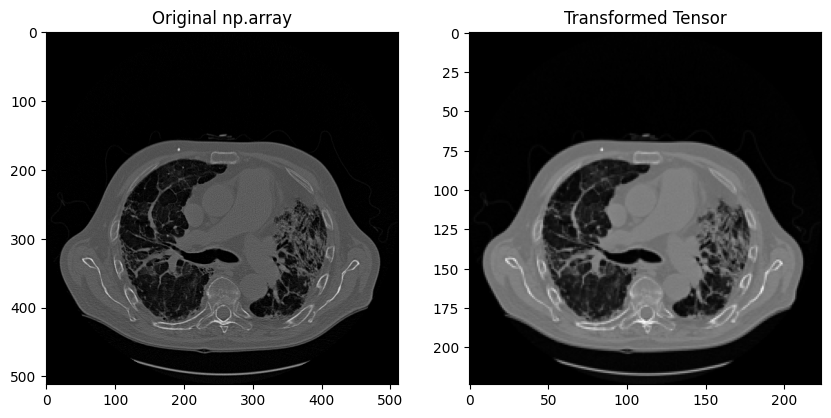

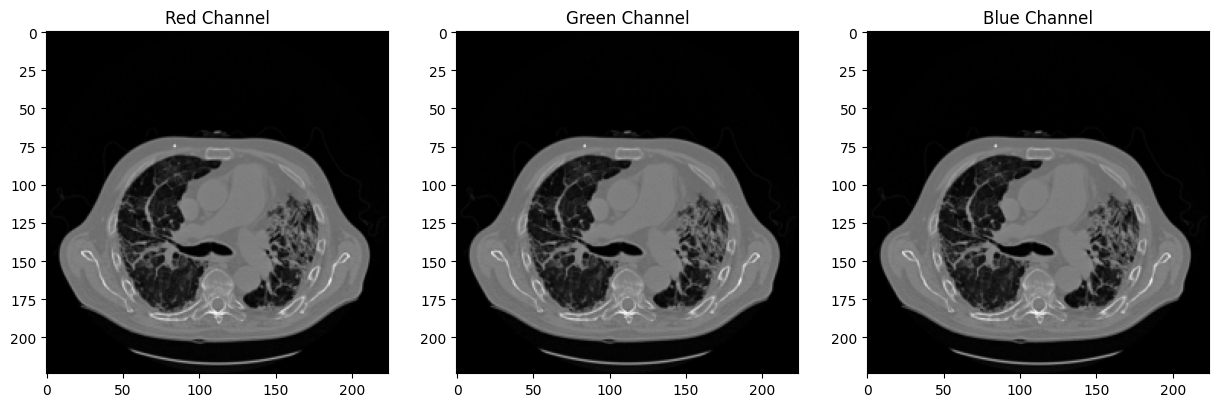

In [41]:
tensorVSnp(train_dataset)

As we can see, the transformation was successful and maintains relative data integrity, but some details were lost. This is due to the resize of (224,224) for ResNet compatibility.

Copying data to create the illusion of RGB for the ResNet input data is not destructive, as the nature of the transformation should not cause any blurriness. It does not apply any smoothing or averaging; it only replicates the grayscale data across the RGB channels. Since the pixel values remain the same across all channels, the image quality is not affected, and the image is not blurred. This is demonstrated in the separate plot of each color channel above.

Therefore, the logical conclusion is that the blurring found in the plot simply portrays the result of normalizing and resizing data, and does not represent data corruption.

## ResNet Training

Important consideration: "0" classification does not mean the lung is healthy. Because ILD manifests itsef in various forms, it is likely that the model could have issues identifying common patterns between:

 - a healthy lung
 - emphysema
 - ground_glass
 - micronodules
 - consolidation
 - bronchial_wall_thickening
 - reticulation
 - macronodules
 - cysts
 - peripheral_micronodules
 - bronchiectasis
 - air_trapping
 - early_fibrosis
 - increased_attenuation
 - tuberculosis
 - pcp

, as they were all paired into "0" classification.

The large variety of possible lung patterns may cause the ResNet to focus on learning residual functions for the presence of unusual structures, **rather than the absence of structures**. 

Additionally, the fact that there were very few slices with fibrosis may help the ResNet specify patterns, especially if their representation was strong and quite different from most of the manifestations represented above.

In [111]:
def trainResNet(train_dataset, val_dataset, num_epochs=55, batch_size=32, lr=5e-7, patience=5, improve_min=0.005):
    # New ResNet instance
    resnet18 = models.resnet18(weights=ResNet18_Weights.DEFAULT)

    # Use only 2 output neurons
    num_ftrs = resnet18.fc.in_features
    resnet18.fc = nn.Linear(num_ftrs, 2)  

    # If graphics card is available, uses it
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    resnet18.to(device)

    print("*"+("-"*29)+"*")
    print("|{:^29}|".format(f"Using {device}"))
    print("*"+("-"*29)+"*")

    # Generate data loaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    
    # Loss function 
    criterion = nn.CrossEntropyLoss()  
    # ADAM
    optimizer = torch.optim.Adam(resnet18.parameters(), lr=lr)

    # Initializing early stop counter (based on validation loss)
    best_loss = 99999999
    early_stop_ctr = 0

    loss_array = []
    val_loss_array = []


    for epoch in range(num_epochs):
        resnet18.train()
        running_loss = 0.0
        running_val_loss = 0.0


        # --------------- Weight updates ---------------
        
        # Iterates over each image in dataset, updates weights
        for images, labels in tqdm((train_loader), desc = "Training..."):
            images, labels = images.to(device), labels.to(device)
            
            # Applies ADAM 
            optimizer.zero_grad()

            # Generates output
            outputs = resnet18(images)

            # Computes loss
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()

        # Computes average training loss
        avg_loss_train = running_loss/len(train_loader)
        print(f"Epoch [{epoch+1}/{num_epochs}], Train loss: {avg_loss_train:.6f}")
        loss_array.append(avg_loss_train)


        # ---------------- Validation Loss -----------------

        # Iterates over each image in dataset, computes validation loss
        for images, labels in (val_loader):
            images, labels = images.to(device), labels.to(device)
            
            # Applies ADAM 
            optimizer.zero_grad()

            # Generates output
            outputs = resnet18(images)

            # Computes loss
            val_loss = criterion(outputs, labels)
            
            running_val_loss += val_loss.item()

        # Computes average validation loss
        avg_loss_val = running_val_loss/len(val_loader)
        print(f"Validation loss: {avg_loss_val:.6f}")
        val_loss_array.append(avg_loss_val)
        

        # Only after a high number of epochs (around 45)
        if epoch > 45:
            # Check for improvement (5% standard)
            if abs(best_loss - avg_loss_val) > (best_loss * improve_min):
                best_loss = avg_loss_val
                early_stop_ctr = 0
            else: early_stop_ctr += 1

            # Checks early stopping condition
            if early_stop_ctr >= patience:
                print(f"Early stopping triggered after {epoch+1} epochs!!!")
                break
    
    return resnet18, loss_array, val_loss_array

In [112]:
models_path = "..\\..\\trainedResNets\\"

ans = str(input("Do you wish to run or read?"))

# Choice execution
if ans == "run": 
    resnet_hrct, hrct_loss, hrct_val_loss = trainResNet(train_dataset,val_dataset)

    with open(r'pickleJar\hrct_loss.pkl', 'wb') as f:
        pickle.dump(hrct_loss, f)

    with open(r'pickleJar\hrct_val_loss.pkl', 'wb') as f:
        pickle.dump(hrct_val_loss, f)

elif ans == "read": 
    resnet_hrct = torch.load((f"{models_path}"+"resnet_hrct.pkl"))

    with open(r'pickleJar\hrct_loss.pkl', 'rb') as f:
        hrct_loss = pickle.load(f)

    with open(r'pickleJar\hrct_val_loss.pkl', 'rb') as f:
        hrct_val_loss = pickle.load(f)
    

else: print("Invalid answer, try again.")

*-----------------------------*
|         Using cuda          |
*-----------------------------*


Training...: 100%|██████████| 55/55 [00:04<00:00, 11.30it/s]


Epoch [1/55], Train loss: 0.796997
Validation loss: 0.819581


Training...: 100%|██████████| 55/55 [00:04<00:00, 11.66it/s]


Epoch [2/55], Train loss: 0.764259
Validation loss: 0.804058


Training...: 100%|██████████| 55/55 [00:04<00:00, 11.71it/s]


Epoch [3/55], Train loss: 0.735457
Validation loss: 0.789159


Training...: 100%|██████████| 55/55 [00:04<00:00, 11.78it/s]


Epoch [4/55], Train loss: 0.712451
Validation loss: 0.775292


Training...: 100%|██████████| 55/55 [00:04<00:00, 11.88it/s]


Epoch [5/55], Train loss: 0.689082
Validation loss: 0.761216


Training...: 100%|██████████| 55/55 [00:04<00:00, 11.79it/s]


Epoch [6/55], Train loss: 0.667296
Validation loss: 0.748006


Training...: 100%|██████████| 55/55 [00:04<00:00, 11.80it/s]


Epoch [7/55], Train loss: 0.645049
Validation loss: 0.734742


Training...: 100%|██████████| 55/55 [00:04<00:00, 11.84it/s]


Epoch [8/55], Train loss: 0.617172
Validation loss: 0.722296


Training...: 100%|██████████| 55/55 [00:04<00:00, 11.87it/s]


Epoch [9/55], Train loss: 0.607968
Validation loss: 0.711005


Training...: 100%|██████████| 55/55 [00:04<00:00, 12.34it/s]


Epoch [10/55], Train loss: 0.589711
Validation loss: 0.698934


Training...: 100%|██████████| 55/55 [00:04<00:00, 12.32it/s]


Epoch [11/55], Train loss: 0.564591
Validation loss: 0.687466


Training...: 100%|██████████| 55/55 [00:04<00:00, 12.27it/s]


Epoch [12/55], Train loss: 0.554432
Validation loss: 0.676666


Training...: 100%|██████████| 55/55 [00:04<00:00, 11.86it/s]


Epoch [13/55], Train loss: 0.536013
Validation loss: 0.665703


Training...: 100%|██████████| 55/55 [00:04<00:00, 11.89it/s]


Epoch [14/55], Train loss: 0.516496
Validation loss: 0.655337


Training...: 100%|██████████| 55/55 [00:04<00:00, 11.86it/s]


Epoch [15/55], Train loss: 0.509355
Validation loss: 0.645233


Training...: 100%|██████████| 55/55 [00:04<00:00, 11.91it/s]


Epoch [16/55], Train loss: 0.487833
Validation loss: 0.635722


Training...: 100%|██████████| 55/55 [00:04<00:00, 11.94it/s]


Epoch [17/55], Train loss: 0.479110
Validation loss: 0.627002


Training...: 100%|██████████| 55/55 [00:04<00:00, 11.93it/s]


Epoch [18/55], Train loss: 0.461517
Validation loss: 0.617557


Training...: 100%|██████████| 55/55 [00:04<00:00, 11.49it/s]


Epoch [19/55], Train loss: 0.448879
Validation loss: 0.609562


Training...: 100%|██████████| 55/55 [00:04<00:00, 11.88it/s]


Epoch [20/55], Train loss: 0.435185
Validation loss: 0.601973


Training...: 100%|██████████| 55/55 [00:04<00:00, 11.93it/s]


Epoch [21/55], Train loss: 0.428003
Validation loss: 0.594083


Training...: 100%|██████████| 55/55 [00:04<00:00, 11.91it/s]


Epoch [22/55], Train loss: 0.414729
Validation loss: 0.586491


Training...: 100%|██████████| 55/55 [00:04<00:00, 11.83it/s]


Epoch [23/55], Train loss: 0.407717
Validation loss: 0.579612


Training...: 100%|██████████| 55/55 [00:04<00:00, 11.92it/s]


Epoch [24/55], Train loss: 0.394732
Validation loss: 0.571994


Training...: 100%|██████████| 55/55 [00:04<00:00, 11.89it/s]


Epoch [25/55], Train loss: 0.384435
Validation loss: 0.564783


Training...: 100%|██████████| 55/55 [00:04<00:00, 11.86it/s]


Epoch [26/55], Train loss: 0.375421
Validation loss: 0.557928


Training...: 100%|██████████| 55/55 [00:04<00:00, 11.99it/s]


Epoch [27/55], Train loss: 0.370730
Validation loss: 0.551367


Training...: 100%|██████████| 55/55 [00:04<00:00, 11.88it/s]


Epoch [28/55], Train loss: 0.358011
Validation loss: 0.545033


Training...: 100%|██████████| 55/55 [00:04<00:00, 11.91it/s]


Epoch [29/55], Train loss: 0.350585
Validation loss: 0.538610


Training...: 100%|██████████| 55/55 [00:04<00:00, 11.90it/s]


Epoch [30/55], Train loss: 0.335448
Validation loss: 0.533206


Training...: 100%|██████████| 55/55 [00:04<00:00, 11.85it/s]


Epoch [31/55], Train loss: 0.332678
Validation loss: 0.527403


Training...: 100%|██████████| 55/55 [00:04<00:00, 11.87it/s]


Epoch [32/55], Train loss: 0.322979
Validation loss: 0.522268


Training...: 100%|██████████| 55/55 [00:04<00:00, 11.90it/s]


Epoch [33/55], Train loss: 0.312235
Validation loss: 0.517072


Training...: 100%|██████████| 55/55 [00:04<00:00, 11.89it/s]


Epoch [34/55], Train loss: 0.305500
Validation loss: 0.512823


Training...: 100%|██████████| 55/55 [00:04<00:00, 11.90it/s]


Epoch [35/55], Train loss: 0.297518
Validation loss: 0.508295


Training...: 100%|██████████| 55/55 [00:04<00:00, 11.91it/s]


Epoch [36/55], Train loss: 0.292316
Validation loss: 0.504673


Training...: 100%|██████████| 55/55 [00:04<00:00, 11.91it/s]


Epoch [37/55], Train loss: 0.283763
Validation loss: 0.500410


Training...: 100%|██████████| 55/55 [00:04<00:00, 11.91it/s]


Epoch [38/55], Train loss: 0.278201
Validation loss: 0.495989


Training...: 100%|██████████| 55/55 [00:04<00:00, 11.93it/s]


Epoch [39/55], Train loss: 0.269152
Validation loss: 0.492535


Training...: 100%|██████████| 55/55 [00:04<00:00, 11.86it/s]


Epoch [40/55], Train loss: 0.265053
Validation loss: 0.489284


Training...: 100%|██████████| 55/55 [00:04<00:00, 11.93it/s]


Epoch [41/55], Train loss: 0.258493
Validation loss: 0.485526


Training...: 100%|██████████| 55/55 [00:04<00:00, 11.93it/s]


Epoch [42/55], Train loss: 0.252745
Validation loss: 0.481890


Training...: 100%|██████████| 55/55 [00:04<00:00, 11.77it/s]


Epoch [43/55], Train loss: 0.246732
Validation loss: 0.478177


Training...: 100%|██████████| 55/55 [00:04<00:00, 11.83it/s]


Epoch [44/55], Train loss: 0.242137
Validation loss: 0.475570


Training...: 100%|██████████| 55/55 [00:04<00:00, 11.80it/s]


Epoch [45/55], Train loss: 0.238517
Validation loss: 0.473434


Training...: 100%|██████████| 55/55 [00:04<00:00, 11.92it/s]


Epoch [46/55], Train loss: 0.233862
Validation loss: 0.470184


Training...: 100%|██████████| 55/55 [00:04<00:00, 12.33it/s]


Epoch [47/55], Train loss: 0.225042
Validation loss: 0.467150


Training...: 100%|██████████| 55/55 [00:04<00:00, 12.36it/s]


Epoch [48/55], Train loss: 0.225545
Validation loss: 0.464667


Training...: 100%|██████████| 55/55 [00:04<00:00, 12.35it/s]


Epoch [49/55], Train loss: 0.225702
Validation loss: 0.462556


Training...: 100%|██████████| 55/55 [00:04<00:00, 12.38it/s]


Epoch [50/55], Train loss: 0.211731
Validation loss: 0.460573


Training...: 100%|██████████| 55/55 [00:04<00:00, 12.30it/s]


Epoch [51/55], Train loss: 0.203949
Validation loss: 0.459619


Training...: 100%|██████████| 55/55 [00:04<00:00, 11.82it/s]


Epoch [52/55], Train loss: 0.200243
Validation loss: 0.456932


Training...: 100%|██████████| 55/55 [00:04<00:00, 11.74it/s]


Epoch [53/55], Train loss: 0.200563
Validation loss: 0.454978


Training...: 100%|██████████| 55/55 [00:04<00:00, 11.74it/s]


Epoch [54/55], Train loss: 0.191592
Validation loss: 0.452769


Training...: 100%|██████████| 55/55 [00:04<00:00, 11.83it/s]


Epoch [55/55], Train loss: 0.192056
Validation loss: 0.451247


In [124]:
ans = str(input("Do you wish to save?"))

if ans == "yes": torch.save(resnet_hrct, (f"{models_path}"+"resnet_hrct.pkl"))
else: print("DID NOT SAVE")

### Generate ROC and Best Threshold

In [115]:
def getROC(model, val_dataset): 

    all_labels, all_scores = [], []
    val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    model.eval()
    with torch.no_grad():
        for images, labels in val_loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)

            # Translate logits to Class 1 probabilities using softmax
            # (pulls column 1 values and assigns probabilities)
            probs = F.softmax(outputs, dim=1)[:, 1]  

            all_scores.extend(probs.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Compute ROC curve
    fpr, tpr, thresholds = roc_curve(all_labels, all_scores)
    roc_auc = auc(fpr, tpr)
    
    # Compute distance to (0,1) for each point on the ROC curve
    distances = np.sqrt((fpr)**2 + (1 - tpr)**2)

    # Gets closest point to the perfect discriminator (0,1)
    best_idx = np.argmin(distances)
    best_threshold = thresholds[best_idx]

    # ---------- Display and Results ---------- 

    plt.figure()
    plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line
    plt.scatter(fpr[best_idx], tpr[best_idx], color='red', label=f'Best Threshold = {best_threshold:.2f}')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc='lower right')
    plt.show()

    print("Area Under Curve:", roc_auc)
    print("Best Threshold (closest to (0,1)):", best_threshold)

    return best_threshold, roc_auc


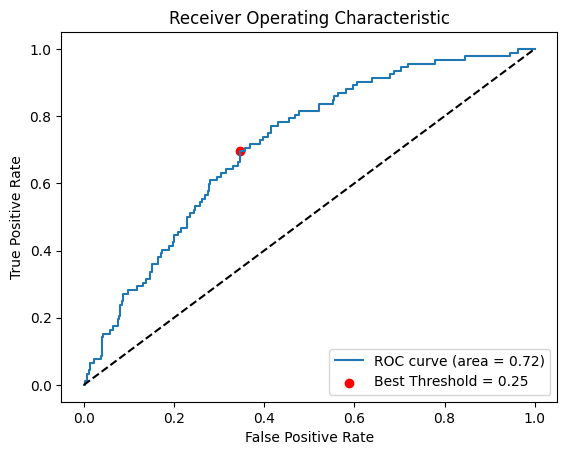

Area Under Curve: 0.7156665468918434
Best Threshold (closest to (0,1)): 0.24636


In [116]:
threshold_hrct, auc_hrct = getROC(resnet_hrct, val_dataset)

### Loss Evolution

In [117]:
def plotLoss(train_loss, val_loss):
    epochs = range(1, len(train_loss) + 1)

    plt.plot(epochs, train_loss, label='Train Loss', marker='o')
    plt.plot(epochs, val_loss, label='Validation Loss', marker='x')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss Evolution')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

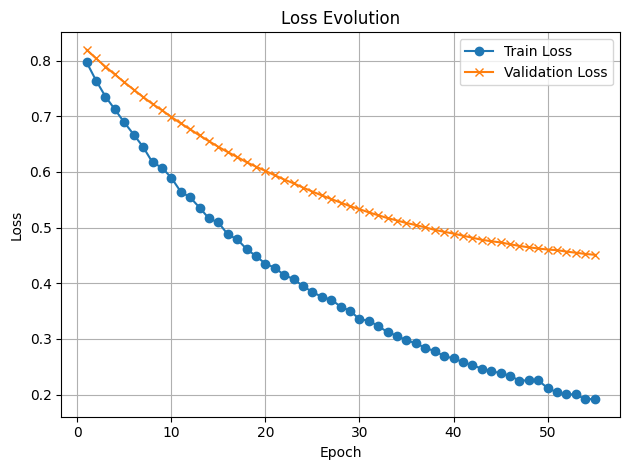

In [118]:
plotLoss(hrct_loss, hrct_val_loss)

In [119]:
def evalResNet(resnet18, test_dataset, threshold, auc):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

    # Counters for each class
    correct, total = 0, 0
    correct_class_0, total_class_0 = 0, 0
    correct_class_1, total_class_1 = 0, 0

    # Needed for F1 score and confusion matrix
    y_true = []
    y_pred = []


    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)

            # Transform outputs to probabilities
            outputs = resnet18(images)

            # Translate logits to Class 1 probabilities using softmax
            probs = F.softmax(outputs, dim=1)[:, 1] 

            # Translate prob vs threshold to predictions
            # True if prob >= threshold else False
            # .long() transforms True/False to 1/0
            predicted = (probs >= threshold).long()
            
            # Update total and correct for general accuracy
            total += labels.size(0)

            correct += (predicted == labels).sum().item()

            # Class-specific accuracy
            for label, pred in zip(labels, predicted):
                if label == 0:
                    total_class_0 += 1
                    if pred == label:
                        correct_class_0 += 1
                elif label == 1:
                    total_class_1 += 1
                    if pred == label:
                        correct_class_1 += 1

            # Add data to lists
            y_true.extend(labels.cpu().tolist())
            y_pred.extend(predicted.cpu().tolist())



    # Weights == inverse proportions
    weight_0, weight_1 = 0.133, 0.867

    print("Total examples:", total)

    # -------------------------------     Perfomance Metrics     -------------------------------

    # Accuracy
    accuracy_class_0 = 100 * (correct_class_0 / total_class_0) if total_class_0 > 0 else 0
    accuracy_class_1 = 100 * (correct_class_1 / total_class_1) if total_class_1 > 0 else 0
    accuracy = 100 * (correct / total)
    accuracy2 = 100 * ((correct_class_0 + correct_class_1) / total)
    weighted_accuracy = ((accuracy_class_0*weight_0) + (accuracy_class_1*weight_1))

    # F1 scores
    f1_macro = f1_score(y_true, y_pred, average='macro') # Assigns same importance to each class
    f1_weighted = f1_score(y_true, y_pred, average='weighted')
    f1_class_0 = f1_score(y_true, y_pred, pos_label=0)
    f1_class_1 = f1_score(y_true, y_pred, pos_label=1)

    # Confusion Matrix
    conf_mat = confusion_matrix(y_true, y_pred)


    # -------------------------------     Print Results     -------------------------------

    # Accuracy
    print("\n --------------------- \n")
    print(f"Accuracy for Class 0: {accuracy_class_0:.2f}%  ({correct_class_0} in {total_class_0})")
    print(f"Accuracy for Class 1: {accuracy_class_1:.2f}%  ({correct_class_1} in {total_class_1})")
    print(f"Test Accuracy: {accuracy:.2f}%")
    if f"{accuracy:.2f}" != f"{accuracy2:.2f}": print("ERROR CALCULATING ACCURACIES")
    print(f"Weighted Accuracy: {weighted_accuracy:.2f}%")

    # AUC
    print("\n --------------------- \n")
    print("Area Under Curve:", auc)

    # F1 scores
    print("\n --------------------- \n")
    print(f"F1 Score (Macro): {f1_macro:.3f}")
    print(f"F1 Score (Weighted): {f1_weighted:.3f}")
    print(f"F1 Score Class 0: {f1_class_0:.3f}")
    print(f"F1 Score Class 1: {f1_class_1:.3f}")

    # Confusion matrix
    print("\n --------------------- \n")
    print("\nConfusion Matrix: \n", conf_mat)

In [120]:
evalResNet(resnet_hrct, test_dataset,threshold_hrct,auc_hrct)

Total examples: 648

 --------------------- 

Accuracy for Class 0: 54.53%  (307 in 563)
Accuracy for Class 1: 85.88%  (73 in 85)
Test Accuracy: 58.64%
Weighted Accuracy: 81.71%

 --------------------- 

Area Under Curve: 0.7156665468918434

 --------------------- 

F1 Score (Macro): 0.524
F1 Score (Weighted): 0.651
F1 Score Class 0: 0.696
F1 Score Class 1: 0.353

 --------------------- 


Confusion Matrix: 
 [[307 256]
 [ 12  73]]


## Conclusions (HRCT_Pilot)

The drastic and different imbalances present in both the training and testing datasets strongly affected the model's ability to learn and identify meaningful patterns in the data. This is clearly portrayed through the difference in accuracy performance when comparing 0-Class and 1-Class. 

## Custom Test Split

The next expected performance analysis will be done on a custom test split, created by the script in `2 - testSplit`. 

In [151]:
# Defining paths
train_df = r"trainTestCustom\train.csv"
test_df = r"trainTestCustom\test.csv"
val_df = r"trainTestCustom\val.csv"

In [152]:
# Paths
img_dir = r'..\..\np_ROI_data'  # CSV with image filenames & labels
annotations_file_train = train_df
annotations_file_test = test_df
annotations_file_val = val_df


# Transformations 
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((224, 224)),  # Resize images to 224x224
    transforms.Lambda(lambda x: x.repeat(3, 1, 1)),  # Convert (1, H, W) → (3, H, W)
])

# Create Datasets
train_dataset = FibrosisDataset(annotations_file_train, img_dir=img_dir, transform=transform)
test_dataset = FibrosisDataset(annotations_file_test, img_dir=img_dir, transform=transform)
val_dataset = FibrosisDataset(annotations_file_val, img_dir=img_dir, transform=transform)

In [153]:
print(torch.cuda.is_available())          
print(torch.cuda.get_device_name(0))     

for i in range(torch.cuda.device_count()):
    print(f"Device {i}: {torch.cuda.get_device_name(i)}")

True
NVIDIA GeForce RTX 3070
Device 0: NVIDIA GeForce RTX 3070


In [155]:
models_path = "..\\..\\trainedResNets\\"

ans = str(input("Do you wish to run or read?"))

# Choice execution
if ans == "run": 
    resnet_custom, custom_loss, custom_val_loss = trainResNet(train_dataset,val_dataset,num_epochs=40)

    with open(r'pickleJar\custom_loss.pkl', 'wb') as f:
        pickle.dump(custom_loss, f)

    with open(r'pickleJar\custom_val_loss.pkl', 'wb') as f:
        pickle.dump(custom_val_loss, f)

elif ans == "read": 
    resnet_custom = torch.load((f"{models_path}"+"resnet_custom.pkl"))

    with open(r'pickleJar\custom_loss.pkl', 'rb') as f:
        custom_loss = pickle.load(f)

    with open(r'pickleJar\custom_val_loss.pkl', 'rb') as f:
        custom_val_loss = pickle.load(f)
    

else: print("Invalid answer, try again.")

*-----------------------------*
|         Using cuda          |
*-----------------------------*


Training...: 100%|██████████| 55/55 [00:05<00:00, 10.97it/s]


Epoch [1/40], Train loss: 0.563253
Validation loss: 0.543179


Training...: 100%|██████████| 55/55 [00:04<00:00, 11.84it/s]


Epoch [2/40], Train loss: 0.532826
Validation loss: 0.533944


Training...: 100%|██████████| 55/55 [00:04<00:00, 11.67it/s]


Epoch [3/40], Train loss: 0.507911
Validation loss: 0.526756


Training...: 100%|██████████| 55/55 [00:04<00:00, 11.79it/s]


Epoch [4/40], Train loss: 0.489643
Validation loss: 0.519758


Training...: 100%|██████████| 55/55 [00:04<00:00, 11.79it/s]


Epoch [5/40], Train loss: 0.469973
Validation loss: 0.513812


Training...: 100%|██████████| 55/55 [00:04<00:00, 12.27it/s]


Epoch [6/40], Train loss: 0.466832
Validation loss: 0.507878


Training...: 100%|██████████| 55/55 [00:04<00:00, 12.19it/s]


Epoch [7/40], Train loss: 0.438961
Validation loss: 0.502698


Training...: 100%|██████████| 55/55 [00:04<00:00, 12.20it/s]


Epoch [8/40], Train loss: 0.431614
Validation loss: 0.497167


Training...: 100%|██████████| 55/55 [00:04<00:00, 12.20it/s]


Epoch [9/40], Train loss: 0.412501
Validation loss: 0.492785


Training...: 100%|██████████| 55/55 [00:04<00:00, 12.25it/s]


Epoch [10/40], Train loss: 0.415674
Validation loss: 0.487969


Training...: 100%|██████████| 55/55 [00:04<00:00, 12.28it/s]


Epoch [11/40], Train loss: 0.390087
Validation loss: 0.483663


Training...: 100%|██████████| 55/55 [00:04<00:00, 12.30it/s]


Epoch [12/40], Train loss: 0.380292
Validation loss: 0.479222


Training...: 100%|██████████| 55/55 [00:04<00:00, 12.23it/s]


Epoch [13/40], Train loss: 0.368769
Validation loss: 0.475000


Training...: 100%|██████████| 55/55 [00:04<00:00, 12.24it/s]


Epoch [14/40], Train loss: 0.360091
Validation loss: 0.470846


Training...: 100%|██████████| 55/55 [00:04<00:00, 12.23it/s]


Epoch [15/40], Train loss: 0.351049
Validation loss: 0.466772


Training...: 100%|██████████| 55/55 [00:04<00:00, 12.20it/s]


Epoch [16/40], Train loss: 0.355762
Validation loss: 0.463548


Training...: 100%|██████████| 55/55 [00:04<00:00, 11.74it/s]


Epoch [17/40], Train loss: 0.332376
Validation loss: 0.459622


Training...: 100%|██████████| 55/55 [00:04<00:00, 11.81it/s]


Epoch [18/40], Train loss: 0.324492
Validation loss: 0.455834


Training...: 100%|██████████| 55/55 [00:04<00:00, 12.09it/s]


Epoch [19/40], Train loss: 0.318760
Validation loss: 0.453039


Training...: 100%|██████████| 55/55 [00:04<00:00, 12.22it/s]


Epoch [20/40], Train loss: 0.308220
Validation loss: 0.449461


Training...: 100%|██████████| 55/55 [00:04<00:00, 12.27it/s]


Epoch [21/40], Train loss: 0.301063
Validation loss: 0.446556


Training...: 100%|██████████| 55/55 [00:04<00:00, 12.26it/s]


Epoch [22/40], Train loss: 0.301426
Validation loss: 0.443774


Training...: 100%|██████████| 55/55 [00:04<00:00, 12.25it/s]


Epoch [23/40], Train loss: 0.287235
Validation loss: 0.441794


Training...: 100%|██████████| 55/55 [00:04<00:00, 12.25it/s]


Epoch [24/40], Train loss: 0.279551
Validation loss: 0.439350


Training...: 100%|██████████| 55/55 [00:04<00:00, 12.24it/s]


Epoch [25/40], Train loss: 0.276478
Validation loss: 0.437142


Training...: 100%|██████████| 55/55 [00:04<00:00, 12.23it/s]


Epoch [26/40], Train loss: 0.268981
Validation loss: 0.434970


Training...: 100%|██████████| 55/55 [00:04<00:00, 12.30it/s]


Epoch [27/40], Train loss: 0.265226
Validation loss: 0.432519


Training...: 100%|██████████| 55/55 [00:04<00:00, 12.31it/s]


Epoch [28/40], Train loss: 0.263784
Validation loss: 0.430837


Training...: 100%|██████████| 55/55 [00:04<00:00, 12.34it/s]


Epoch [29/40], Train loss: 0.250514
Validation loss: 0.430194


Training...: 100%|██████████| 55/55 [00:04<00:00, 12.26it/s]


Epoch [30/40], Train loss: 0.246110
Validation loss: 0.428279


Training...: 100%|██████████| 55/55 [00:04<00:00, 12.30it/s]


Epoch [31/40], Train loss: 0.241082
Validation loss: 0.426114


Training...: 100%|██████████| 55/55 [00:04<00:00, 12.38it/s]


Epoch [32/40], Train loss: 0.234843
Validation loss: 0.424142


Training...: 100%|██████████| 55/55 [00:04<00:00, 12.27it/s]


Epoch [33/40], Train loss: 0.234417
Validation loss: 0.422745


Training...: 100%|██████████| 55/55 [00:04<00:00, 12.28it/s]


Epoch [34/40], Train loss: 0.225816
Validation loss: 0.421890


Training...: 100%|██████████| 55/55 [00:04<00:00, 12.21it/s]


Epoch [35/40], Train loss: 0.218977
Validation loss: 0.420504


Training...: 100%|██████████| 55/55 [00:04<00:00, 12.32it/s]


Epoch [36/40], Train loss: 0.217644
Validation loss: 0.419216


Training...: 100%|██████████| 55/55 [00:04<00:00, 12.24it/s]


Epoch [37/40], Train loss: 0.212597
Validation loss: 0.418216


Training...: 100%|██████████| 55/55 [00:04<00:00, 12.34it/s]


Epoch [38/40], Train loss: 0.207488
Validation loss: 0.417294


Training...: 100%|██████████| 55/55 [00:04<00:00, 12.07it/s]


Epoch [39/40], Train loss: 0.202280
Validation loss: 0.416347


Training...: 100%|██████████| 55/55 [00:04<00:00, 11.98it/s]


Epoch [40/40], Train loss: 0.198190
Validation loss: 0.414869


In [156]:
ans = str(input("Do you wish to save?"))

if ans == "yes": torch.save(resnet_custom, (f"{models_path}"+"resnet_custom.pkl"))
else: print("DID NOT SAVE")

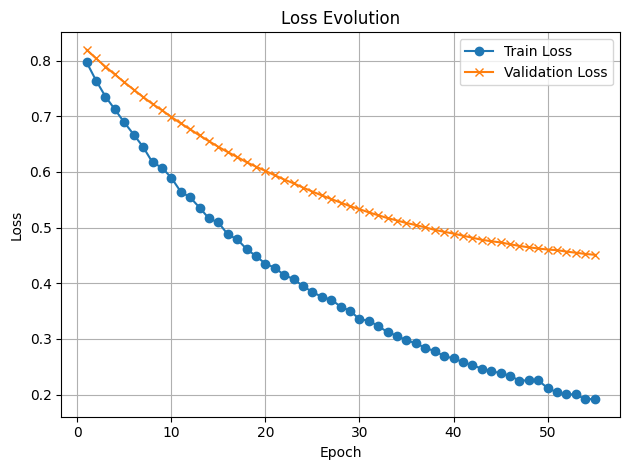

In [157]:
plotLoss(hrct_loss, hrct_val_loss)

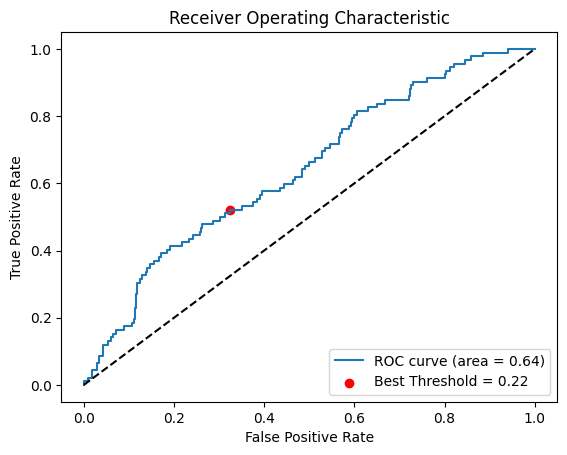

Area Under Curve: 0.6420229967660798
Best Threshold (closest to (0,1)): 0.22451372


In [158]:
threshold_custom, auc_custom = getROC(resnet_custom, val_dataset)

In [159]:
evalResNet(resnet_custom, test_dataset, threshold_custom,auc_custom)

Total examples: 648

 --------------------- 

Accuracy for Class 0: 56.48%  (318 in 563)
Accuracy for Class 1: 77.65%  (66 in 85)
Test Accuracy: 59.26%
Weighted Accuracy: 74.83%

 --------------------- 

Area Under Curve: 0.6420229967660798

 --------------------- 

F1 Score (Macro): 0.520
F1 Score (Weighted): 0.658
F1 Score Class 0: 0.707
F1 Score Class 1: 0.333

 --------------------- 


Confusion Matrix: 
 [[318 245]
 [ 19  66]]


## Custom test split and augmentations

The initial idea consisted of creating new slice files by applying the transformations mentioned in `1 - dataPreprocessing`, with guaranteed effect. However, after consultation with advisor, the new process consists of applying successive transofrmations with some degree of probability of non-application, as well as introudction of a new augmantation technique (Gaussian Blur). 

These methods should improve overall generalization.

In [160]:
# Paths
img_dir = r'..\..\np_ROI_data'  # CSV with image filenames & labels
annotations_file_train = train_df
annotations_file_test = test_df
annotations_file_val = val_df

# Transformations 
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((224, 224)),  # Resize images to 224x224
    transforms.Lambda(lambda x: x.repeat(3, 1, 1)),  # Convert (1, H, W) → (3, H, W)
])

# Augmentations
augment = A.Compose([
    # Rotate
    A.Rotate(limit=(-350,30), p=0.8),
    # Translate
    A.Affine(translate_percent={"x":(-0.15,0.15), "y":{-0.23,0.25}},
              rotate=0, scale=1, p=0.8),
    # Shear
    A.Affine(shear={"x":(-15,15), "y":(-15,15)},p=0.8)
])

# Randomized Gaussian Noise and Blur
gauss = True

# Create Datasets
train_dataset = FibrosisDataset(annotations_file_train, img_dir=img_dir, transform=transform, albumentations=augment, gauss=gauss)
test_dataset = FibrosisDataset(annotations_file_test, img_dir=img_dir, transform=transform)
val_dataset = FibrosisDataset(annotations_file_test, img_dir=img_dir, transform=transform)

SliceID at index 643: 164__CT-0002-0002.npy
(224, 224, 3)


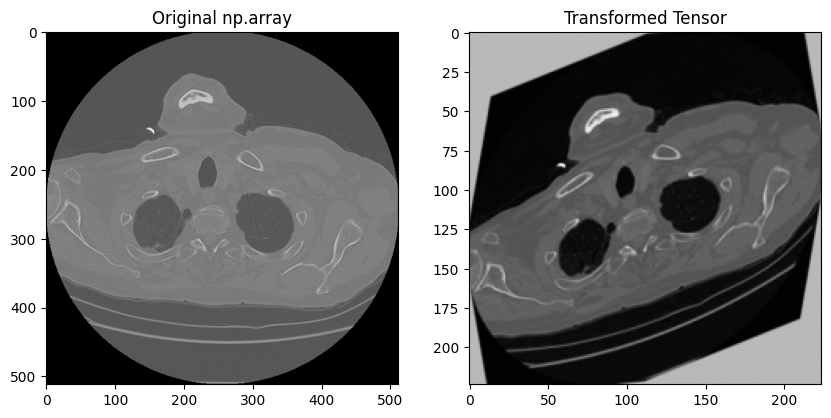

In [161]:
tensorVSnp(train_dataset, False)

In [165]:
models_path = "..\\..\\trainedResNets\\"

ans = str(input("Do you wish to run or read?"))

# Choice execution
if ans == "run": 
    resnet_custom_aug, custom_aug_loss, custom_aug_val_loss = trainResNet(train_dataset,val_dataset,num_epochs=40)

    with open(r'pickleJar\custom_aug_loss.pkl', 'wb') as f:
        pickle.dump(custom_aug_loss, f)

    with open(r'pickleJar\custom_aug_val_loss.pkl', 'wb') as f:
        pickle.dump(custom_aug_val_loss, f)

elif ans == "read": 
    resnet_custom_aug = torch.load((f"{models_path}"+"resnet_custom_aug.pkl"))

    with open(r'pickleJar\custom_aug_loss.pkl', 'rb') as f:
        custom_aug_loss = pickle.load(f)

    with open(r'pickleJar\custom_aug_val_loss.pkl', 'rb') as f:
        custom_aug_val_loss = pickle.load(f)
    

else: print("Invalid answer, try again.")

*-----------------------------*
|         Using cuda          |
*-----------------------------*


Training...: 100%|██████████| 55/55 [00:27<00:00,  2.00it/s]


Epoch [1/40], Train loss: 0.801693
Validation loss: 0.757807


Training...: 100%|██████████| 55/55 [00:27<00:00,  2.01it/s]


Epoch [2/40], Train loss: 0.769326
Validation loss: 0.742417


Training...: 100%|██████████| 55/55 [00:27<00:00,  2.00it/s]


Epoch [3/40], Train loss: 0.755262
Validation loss: 0.727729


Training...: 100%|██████████| 55/55 [00:27<00:00,  2.02it/s]


Epoch [4/40], Train loss: 0.734500
Validation loss: 0.714217


Training...: 100%|██████████| 55/55 [00:27<00:00,  2.02it/s]


Epoch [5/40], Train loss: 0.728604
Validation loss: 0.701904


Training...: 100%|██████████| 55/55 [00:27<00:00,  2.02it/s]


Epoch [6/40], Train loss: 0.700027
Validation loss: 0.689880


Training...: 100%|██████████| 55/55 [00:27<00:00,  2.02it/s]


Epoch [7/40], Train loss: 0.689532
Validation loss: 0.678681


Training...: 100%|██████████| 55/55 [00:27<00:00,  2.02it/s]


Epoch [8/40], Train loss: 0.671960
Validation loss: 0.667609


Training...: 100%|██████████| 55/55 [00:27<00:00,  2.02it/s]


Epoch [9/40], Train loss: 0.651532
Validation loss: 0.656971


Training...: 100%|██████████| 55/55 [00:27<00:00,  2.04it/s]


Epoch [10/40], Train loss: 0.642014
Validation loss: 0.646847


Training...: 100%|██████████| 55/55 [00:27<00:00,  2.03it/s]


Epoch [11/40], Train loss: 0.633190
Validation loss: 0.637094


Training...: 100%|██████████| 55/55 [00:27<00:00,  2.02it/s]


Epoch [12/40], Train loss: 0.626445
Validation loss: 0.627912


Training...: 100%|██████████| 55/55 [00:27<00:00,  2.02it/s]


Epoch [13/40], Train loss: 0.609081
Validation loss: 0.618879


Training...: 100%|██████████| 55/55 [00:27<00:00,  2.02it/s]


Epoch [14/40], Train loss: 0.603359
Validation loss: 0.610496


Training...: 100%|██████████| 55/55 [00:27<00:00,  2.03it/s]


Epoch [15/40], Train loss: 0.579832
Validation loss: 0.602109


Training...: 100%|██████████| 55/55 [00:27<00:00,  2.01it/s]


Epoch [16/40], Train loss: 0.575456
Validation loss: 0.593758


Training...: 100%|██████████| 55/55 [00:12<00:00,  4.55it/s]


Epoch [17/40], Train loss: 0.566024
Validation loss: 0.585822


Training...: 100%|██████████| 55/55 [00:27<00:00,  2.03it/s]


Epoch [18/40], Train loss: 0.556487
Validation loss: 0.578032


Training...: 100%|██████████| 55/55 [00:27<00:00,  2.03it/s]


Epoch [19/40], Train loss: 0.545500
Validation loss: 0.570919


Training...: 100%|██████████| 55/55 [00:27<00:00,  2.02it/s]


Epoch [20/40], Train loss: 0.535026
Validation loss: 0.563714


Training...: 100%|██████████| 55/55 [00:27<00:00,  2.02it/s]


Epoch [21/40], Train loss: 0.531894
Validation loss: 0.556701


Training...: 100%|██████████| 55/55 [00:28<00:00,  1.95it/s]


Epoch [22/40], Train loss: 0.514695
Validation loss: 0.550030


Training...: 100%|██████████| 55/55 [00:27<00:00,  2.03it/s]


Epoch [23/40], Train loss: 0.504871
Validation loss: 0.543410


Training...: 100%|██████████| 55/55 [00:26<00:00,  2.07it/s]


Epoch [24/40], Train loss: 0.512925
Validation loss: 0.536912


Training...: 100%|██████████| 55/55 [00:26<00:00,  2.08it/s]


Epoch [25/40], Train loss: 0.496003
Validation loss: 0.530674


Training...: 100%|██████████| 55/55 [00:26<00:00,  2.09it/s]


Epoch [26/40], Train loss: 0.490629
Validation loss: 0.524333


Training...: 100%|██████████| 55/55 [00:26<00:00,  2.09it/s]


Epoch [27/40], Train loss: 0.482799
Validation loss: 0.518531


Training...: 100%|██████████| 55/55 [00:26<00:00,  2.09it/s]


Epoch [28/40], Train loss: 0.476322
Validation loss: 0.513178


Training...: 100%|██████████| 55/55 [00:26<00:00,  2.08it/s]


Epoch [29/40], Train loss: 0.470006
Validation loss: 0.507569


Training...: 100%|██████████| 55/55 [00:26<00:00,  2.08it/s]


Epoch [30/40], Train loss: 0.461796
Validation loss: 0.502156


Training...: 100%|██████████| 55/55 [00:26<00:00,  2.09it/s]


Epoch [31/40], Train loss: 0.454745
Validation loss: 0.496920


Training...: 100%|██████████| 55/55 [00:26<00:00,  2.09it/s]


Epoch [32/40], Train loss: 0.450621
Validation loss: 0.491815


Training...: 100%|██████████| 55/55 [00:26<00:00,  2.08it/s]


Epoch [33/40], Train loss: 0.447707
Validation loss: 0.486589


Training...: 100%|██████████| 55/55 [00:26<00:00,  2.08it/s]


Epoch [34/40], Train loss: 0.432022
Validation loss: 0.482211


Training...: 100%|██████████| 55/55 [00:26<00:00,  2.08it/s]


Epoch [35/40], Train loss: 0.426602
Validation loss: 0.477755


Training...: 100%|██████████| 55/55 [00:26<00:00,  2.08it/s]


Epoch [36/40], Train loss: 0.424148
Validation loss: 0.473459


Training...: 100%|██████████| 55/55 [00:26<00:00,  2.09it/s]


Epoch [37/40], Train loss: 0.420355
Validation loss: 0.469001


Training...: 100%|██████████| 55/55 [00:26<00:00,  2.07it/s]


Epoch [38/40], Train loss: 0.414610
Validation loss: 0.464707


Training...: 100%|██████████| 55/55 [00:26<00:00,  2.08it/s]


Epoch [39/40], Train loss: 0.409797
Validation loss: 0.460950


Training...: 100%|██████████| 55/55 [00:26<00:00,  2.09it/s]


Epoch [40/40], Train loss: 0.399542
Validation loss: 0.457002


In [166]:
ans = str(input("Do you wish to save?"))

if ans == "yes": torch.save(resnet_custom_aug, (f"{models_path}"+"resnet_custom_aug.pkl"))
else: print("DID NOT SAVE")

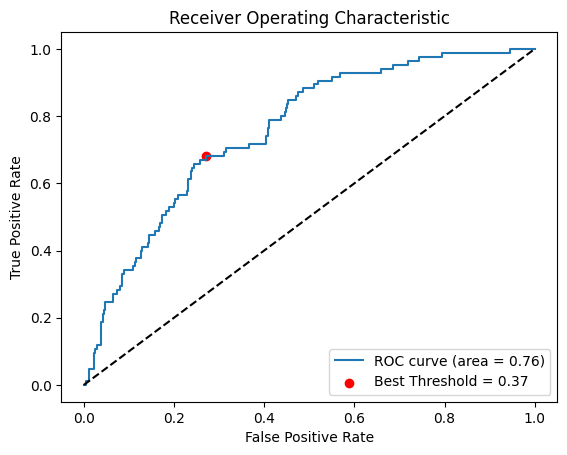

Area Under Curve: 0.7593354926339985
Best Threshold (closest to (0,1)): 0.36896533


In [167]:
threshold_custom_aug, auc_augment = getROC(resnet_custom_aug, val_dataset)

In [168]:
evalResNet(resnet_custom_aug, test_dataset, threshold_custom_aug, auc_augment)

Total examples: 648

 --------------------- 

Accuracy for Class 0: 72.82%  (410 in 563)
Accuracy for Class 1: 68.24%  (58 in 85)
Test Accuracy: 72.22%
Weighted Accuracy: 68.85%

 --------------------- 

Area Under Curve: 0.7593354926339985

 --------------------- 

F1 Score (Macro): 0.606
F1 Score (Weighted): 0.764
F1 Score Class 0: 0.820
F1 Score Class 1: 0.392

 --------------------- 


Confusion Matrix: 
 [[410 153]
 [ 27  58]]


In [169]:
ans = str(input("Do you wish to save models? (WARNING: OVERWRITES!!!)"))

if ans.lower() == 'yes':
    torch.save(resnet_hrct, (f"{models_path}"+"resnet_hrct.pkl"))
    torch.save(resnet_custom, (f"{models_path}"+"resnet_custom.pkl"))
    torch.save(resnet_custom_aug, (f"{models_path}"+"resnet_custom_aug.pkl"))